# Project 2

## Topic : Stereo reconstruction and Non-linear optimization

#### Instructions
<ul>
    <li> The second project of the course is designed to get you familiar with stereo reconstruction, and non-linear optimization </li>
    <li> Use python for this project. PILLOW and OpenCV are permitted for image I/O. </li>
    <li> Submit this notebook as a zipped file on moodle. The format should be $<$team_id$>$_$<$team_ name$>$.zip. Both members have to submit this zip file. </li>
    <li> A seperate report is not needed if you're coding in the notebook itself. Please provide adequate descriptions of the approaches you've taken. Also mention work distribution for the two members. </li>
    <li> Refer to the late day policy. Start early </li> 
    <li> Download data from here: https://iiitaphyd-my.sharepoint.com/:f:/g/personal/aryan_sakaria_students_iiit_ac_in/Er5C7351IAlFsvwHUesFeSQBQtlSiAS7AORSEJT2qH_8_w?e=ol98k9  </li>
</ul>

----
### PART 1: Stereo dense reconstruction

3-D point clouds are very useful in robotics for several tasks such as object detection, motion estimation (3D-3D matching or 3D-2D matching), SLAM, and other forms of scene understanding.  Stereo cameras provide  us  with  a  convenient  way  to  generate  dense  point  clouds. Dense here,  in  contrast  to sparse, means all the image points are used for the reconstruction.  In this part of the assignment you will be generating a dense 3D point cloud reconstruction of a scene from stereo images.

#### Procedure: 

<ol>
    <li> Generate a disparity map for each stereo pair.  Use OpenCV (e.g.  StereoSGBM) for this.  Note that the images provided are already rectified and undistorted. </li>
    <li> Then, using the camera parameters and baseline information generate colored point clouds from each disparity map.  Some points will have invalid disparity values, so ignore them.  Use [Open3D]for storing your point clouds. </li>
    <li> Register (or transform) all the generated point clouds into your world frame by using the providedground truth poses. </li>
    <li> Visualize the registered point cloud data, in color.  Use Open3D for this </li>
</ol>
    

In [1]:
#import libraries:
import numpy as np 
# from sklearn.preprocessing import normalize #normalizing gives better results. Experiment with this
import cv2
import open3d as o3d
import matplotlib.pyplot as plt
import os
from funcs import *
import numpy.linalg as LA
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import svds, eigs, inv
from tqdm import tqdm
from copy import deepcopy

In [2]:
def read_transformations(filename='poses.txt'):
    f = open(filename, 'r')
    lines = f.readlines()
    transformation_list = []
    for i in range(len(lines)):
        transformation_list_temp = lines[i].split()
        temp_rot = [] 
        temp_rot.append( (transformation_list_temp[0:4] ) ) 
        temp_rot.append( (transformation_list_temp[4:8]  ) ) 
        temp_rot.append( (transformation_list_temp[8:12]  ) ) 
        transformation_list.append(np.array(temp_rot,dtype = np.float32))
    return transformation_list

def read_camera_calib(filename='calib.txt'):
    f = open(filename, 'r')
    lines = f.readlines()
    K = np.reshape(np.array(np.float64(lines[1].split())),[3,3])
    b = np.array(np.float64(lines[4].split()[0]))
    return K,b

def get_3D_pts(disparity,K,b,im_left,thresh = 2.8, return_img_pts = False):
    
    
    f = K[0,0]
    x0,y0 = K[0,2], K[1,2]
    
    Q_mat = np.array([
        [1,  0,    0, -x0],
        [0, -1,    0,  y0],
        [0,  0,    0,   f],
        [0,  0, -1/b,   0]
    ])
    
    thresh = thresh
        
    colors = im_left.reshape(-1,3).astype('float64')/255
    h,w = im_left.shape[:2]
    coord_x, coord_y = np.meshgrid(np.arange(w),np.arange(h))
    coord_x, coord_y = coord_x.ravel(), coord_y.ravel()
    disparity = disparity.ravel()
    
    coord_x, coord_y = coord_x[disparity > thresh], coord_y[disparity > thresh]
    colors = colors[disparity > thresh]
    disparity = disparity[disparity > thresh]
    

    
    coords = np.vstack((coord_x, coord_y, disparity, np.ones(len(disparity))))
    coords = Q_mat @ coords
    coords = coords/coords[-1,:]
    
    if(return_img_pts):
        return coords, colors, np.vstack((coord_x, coord_y)).T
    
    return coords, colors
    
transformation_list = read_transformations() 
K,b = read_camera_calib()

In [3]:
im_list1 = [cv2.cvtColor( cv2.imread(os.path.join('./img2/',im)), cv2.COLOR_BGR2RGB) for im in os.listdir('./img2/')]
im_list2 = [cv2.cvtColor( cv2.imread(os.path.join('./img3/',im)), cv2.COLOR_BGR2RGB) for im in os.listdir('./img3/')]

sz = len(im_list1)

window_size = 5
minDis = -16
numDis = 128

stereo = cv2.StereoSGBM_create(minDisparity=minDis,
    numDisparities=numDis,
    blockSize=window_size,
    P1=8 * 3 * window_size ** 2,
    P2=64 * 3 * window_size ** 2,
    disp12MaxDiff=1,
    uniquenessRatio=10,
    speckleWindowSize=100,
    speckleRange=32,
    preFilterCap=63
#     mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
)

disparity_list = [(stereo.compute(im_list1[i],im_list2[i]) - minDis)/numDis for i in range(sz)]

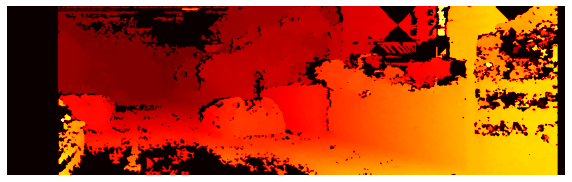

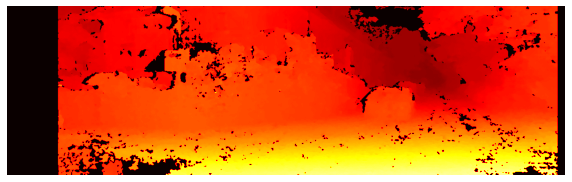

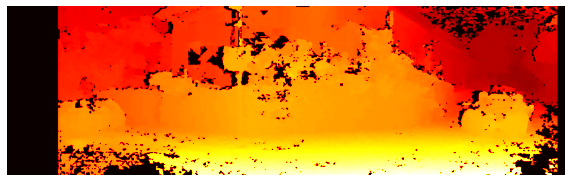

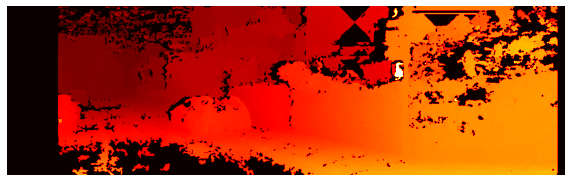

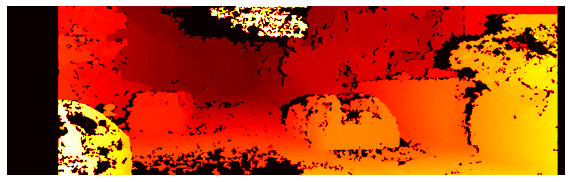

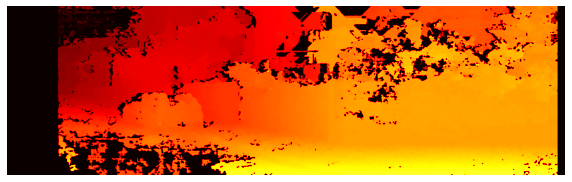

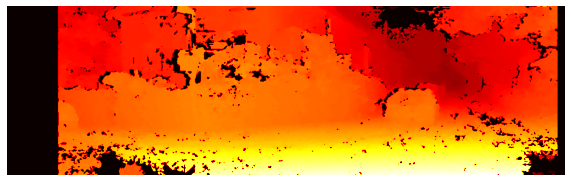

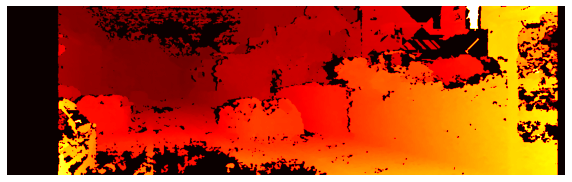

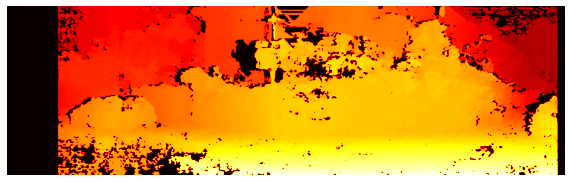

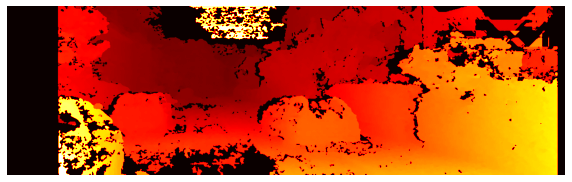

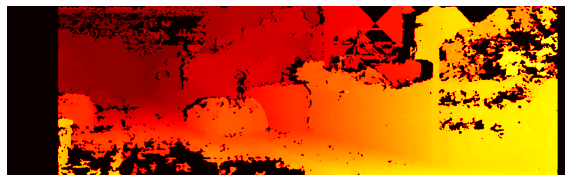

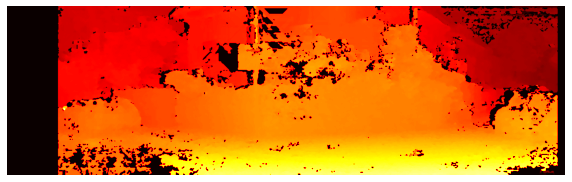

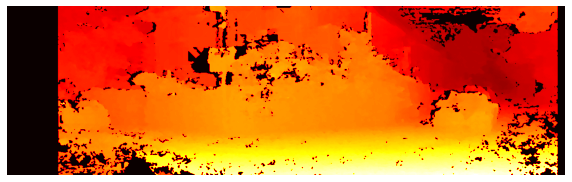

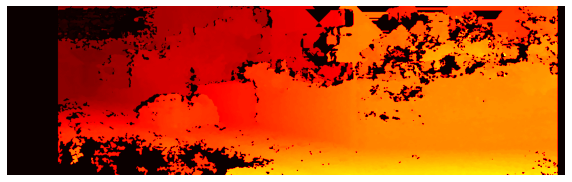

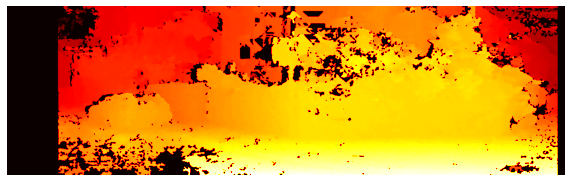

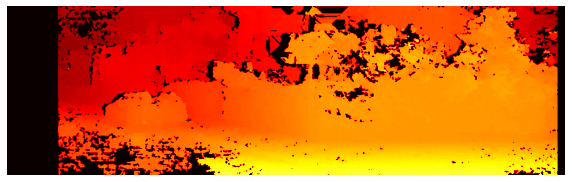

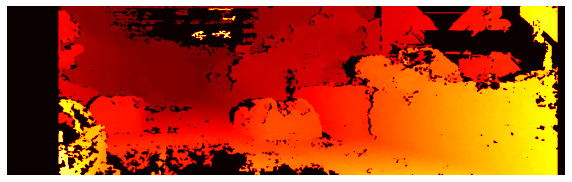

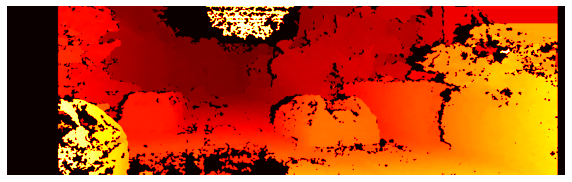

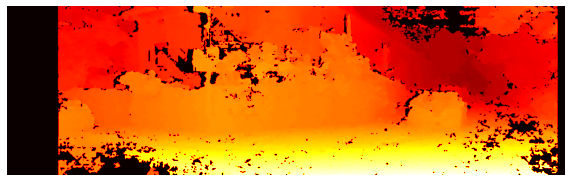

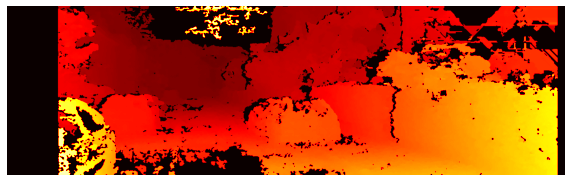

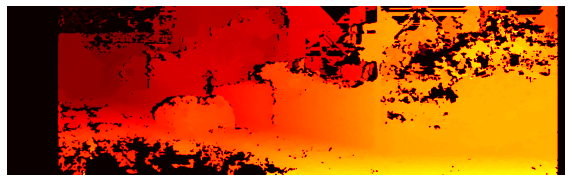

In [4]:
for i in range(len(disparity_list)):
    plt.figure(figsize = [10,8])
    plt.imshow(disparity_list[i],cmap='hot')
    plt.axis('off')
    plt.show()

In [5]:
for i in range(sz):
    im_left = im_list1[i]
    pts,colors = get_3D_pts(disparity_list[i],K,b,im_left,thresh = 2.81)
    
    P_mat = transformation_list[i]
    pts = (P_mat @  pts).T
    pcl = o3d.geometry.PointCloud()
    pcl.points = o3d.utility.Vector3dVector(pts) 
    pcl.colors = o3d.utility.Vector3dVector(colors)
    
    if(i == 0):
        final_pcl = pcl
    else:
        final_pcl = final_pcl + pcl
    
#     if(i == 0): break
o3d.io.write_point_cloud('./Part1_pcl.ply', final_pcl)
o3d.visualization.draw_geometries([final_pcl])

Provide explanation in this cell: 

# Introduction
Distance estimation is an important measurement for applications in Automated Driving and Robotics. A cost-effective way of performing distance estimation is by using stereo camera vision. With a stereo camera, depth can be inferred from point correspondences using triangulation. Depth at any given point can be computed if the disparity at that point is known. Disparity measures the displacement of a point between two images. The higher the disparity, the closer the object.
</br></br>
When you take a picture with two parallel cameras (or in a case two pictures with the same camera but moved), you know that one picture will contain the points of the other along an epipolar line. The image below which shows a basic setup with two cameras taking the image of same scene.

<center>
    <img src="./Assets/cam.jpeg">
</center>

If we are using only the left camera, we can't find the 3D point corresponding to the point $x$ in image because every point on the line OX projects to the same point on the image plane. But consider the right image also. Now different points on the line $OX$ projects to different points ( $x^{'}$) in right plane. So with these two images, we can triangulate the correct 3D point.</br></br>
The projection of the different points on $OX$ form a line on right plane (line $l′$). We call it epiline corresponding to the point $x$. It means, to find the point $x$ on the right image, search along this epiline. It should be somewhere on this line. This is called Epipolar Constraint. Similarly all points will have its corresponding epilines in the other image. The plane $XOO′$ is called Epipolar Plane.
## Disparity Map

Disparity refers to the difference in location of an object in corresponding two (left and right) images as seen by the left and right eye which is created due to parallax (eyes’ horizontal separation). The brain uses this disparity to calculate depth information from the two dimensional images.
</br></br>
In short, The disparity of a pixel is equal to the shift value that leads to minimum sum-of-squared-differences for that pixel.
</br></br>
The term disparity was used to describe the 2D vector between the positions of corresponding features seen by the left and right eyes. It is inversely proportional to depth, and it is possible to define a mapping from an (x,y,d) triple to a three-dimensional position.
</br></br>
Consider the following setup, we can derive a homogeneous representation for the world coodinates $X$,$Y$,$Z$.
<center>
    <img src="./Assets/stereo_tr.png">
</center>
</br>
$$\begin{equation}\begin{bmatrix}
U \\ V \\ W \\ T
\end{bmatrix} = \begin{bmatrix}
B & 0 & 0 & -c_{x}\\ 0 & B & 0 & -c_{y} \\ 0 & 0 & B\cdot c & 0 \\ 0 & 0 & 0 & 1\\
\end{bmatrix}\cdot\begin{bmatrix}
x' \\ y' \\ 1 \\ p_{x}
\end{bmatrix}\end{equation}
$$

or

$$\begin{equation}\begin{bmatrix}
U \\ V \\ W \\ T
\end{bmatrix} = \begin{bmatrix}
1 & 0 & 0 & -c_{x}\\ 0 & 1 & 0 & -c_{y} \\ 0 & 0 & c & 0 \\ 0 & 0 & -1/B & 0\\
\end{bmatrix}\cdot\begin{bmatrix}
x' \\ y' \\ p_{x} \\ 1
\end{bmatrix}\end{equation}
$$


where $B$ is the Baselength, $c_{x}$ is the sensor shift in $x$, $c_{y}$ is the sensor shift in $y$, $c$ is the camera constant,$x'$ is the x co-ordinate in left image, $y'$ is the y image co-ordinate in right image, and $p_{x}$ is the disparity.

Disparity estimation algorithms fall into two broad categories: local methods and global methods. 
* Local methods evaluate one pixel at a time, considering only neighboring pixels. Local methods are poor at detecting sudden depth variation and occlusions.
* Global methods consider information that is available in the whole image.
* Semi-global matching uses information from neighboring pixels in multiple directions to calculate the disparity of a pixel. 
Analysis in multiple directions results in a lot of computation. Instead of using the whole image, the disparity of a pixel can be calculated by considering a smaller block of pixels for ease of computation. Thus, the Semi-Global Block Matching (SGBM) algorithm uses block-based cost matching that is smoothed by path-wise information from multiple directions.

## SGBM

Using the block-based approach, this algorithm estimates approximate disparity of a pixel in the left image from the same pixel in the right image. Before going into the algorithm and implementation details, two important parameters need to be understood: Disparity Levels and Number of Directions.

* Disparity levels: Is a parameter used to define the search space for matching.
* Number of Directions: In the SGBM algorithm, to optimize the cost function, the input image is considered from multiple directions.

The SGBM algorithm takes a pair of rectified left and right images as input. Images need to be rectified before performing stereo matching to make all epi-polar lines parallel to the horizontal axis and match vertical coordinates of each corresponding pixel.
</br></br>
The SGBM algorithm implementation has three major modules: Matching Cost Calculation, Directional Cost Calculation and Post-processing.

### Matching Cost Calculation
This module can be divided into two steps: Center-Symmetric Census Transform (CSCT) of left and right images and Hamming Distance computation. In the Hamming Distance module, the CSCT outputs of the left and right images are pixel-wise XOR'd and set bits are counted to generate the matching cost for each disparity level. To generate $D$ disparity levels, $D$ pixel-wise Hamming distance computation blocks are used. The matching cost for $D$ disparity levels at a given pixel position, $p$, in the left image is computed by computing the Hamming distance with ($p$ to $D+p$) pixel positions in the right image. The matching cost, $C(p,d)$, is computed at each pixel position, $p$, for each disparity level, $d$.
</br>
</br>
### Directional Cost Calculation
In general, due to noise, the matching cost result is ambiguous and some wrong matches could have lower cost than correct ones. Therefore additional constraints are required to increase smoothness by penalizing changes of neighboring disparities. This constraint is realized by aggregating 1-D minimum cost paths from multiple directions.
</br>
</br>
### Post-processing.
This module has three steps: minimum cost index calculation, interpolation, and a uniqueness function. Minimum cost index calculation finds the index corresponding to the minimum cost for a given pixel. Sub-pixel quadratic interpolation is applied on the index to resolve disparities at the sub-pixel level. The uniqueness function ensures reliability of the computed minimum disparity. A higher value of the uniqueness threshold marks more disparities unreliable. As a last step, the negative disparity values are invalidated and replaced with -1.
</br>
</br>

# References
[1] H. Hirschmuller, "Accurate and efficient stereo processing by semi-global matching and mutual information," 2005 IEEE Computer Society Conference on Computer Vision and Pattern Recognition (CVPR'05), San Diego, CA, USA, 2005</br>
[2] Spangenberg, R., T. Langner and R. Rojas. “Weighted Semi-Global Matching and Center-Symmetric Census Transform for Robust Driver Assistance.” CAIP (2013).</br>

# Results

PointCloud of the constructed scene:
<center>
    <img src="./Assets/pcd1.png">
</center>
</br>
<center>
    <img src="./Assets/pcd2.png">
</center>
</br>
Disparity Map for one of the stereo pairs as a heatmap:
<center>
    <img src="./Assets/disp.png">
</center>

In [6]:
pcd = o3d.io.read_point_cloud("./Part1_pcl.ply")
o3d.visualization.draw_geometries([pcd])

----
### PART 2: Motion estimation using iterative PnP

Using the generated reconstruction from the previous part, synthesize a new image taken by a virtualmonocular camera fixed at any arbitrary position and orientation.  Your task in this part is to recoverthis pose using an iterative Perspective-from-n-Points (PnP) algorithm. 

#### Procedure: 

<ol>
    <li> Obtain a set of 2D-3D correspondences between the the image and the point cloud.  Since hereyou’re generating the image, this should be easy to obtain. </li>
    <li> For this set of correspondences compute the total reprojection error c= $\sum_{i} ‖x_i−P_{k}X_i‖^2 $    where $P_{k}= K[R_{k}|t_{k}]$, $X_{i}$ is the 3D point in the world frame, $x_{i}$ is its corresponding projection. </li>
    <li> Solve for the pose $T_{k}$ that minimizes this non-linear reprojection error using a Gauss-Newton (GN)scheme.  Recall that in GN we start with some initial estimated value $x_{o}$ and iteratively refine the estimate using $x_{1}$= $∆x+x_0$, where $∆x$ is obtained by solving the normal equations $J^{T}J∆x$= -$J^{T}e$, until convergence.The main steps in this scheme are computing the corresponding Jacobians and updating the estimates correctly.  For our problem,  use a 12×1 vector parameterization for $T_{k}$(the top 3×4submatrix).  Run the optimization for different choices of initialization and report your observations. </li>
</ol>

In [6]:
def dlt(world_pt,im_pt,K):
#     N=np.array([[2/370,0,-1],[0,2/1226,-1],[0,0,1]])
#     im_pt = (N@np.insert(im_pt,2,1,axis=1).T).T[:,:-1] #Normalisation
    wp1 = world_pt
    wp = np.stack((wp1,wp1),2).transpose(0,2,1).reshape(2*wp1.shape[0],4)
    wp_mat = np.hstack((wp,wp,wp))
    tmp_mat = np.tile(np.hstack((np.vstack((-1*np.ones(4),np.zeros(4))),np.vstack((np.zeros(4),-1*np.ones(4))))),(wp1.shape[0],1))
    im_mat = np.hstack((tmp_mat,np.tile(im_pt.ravel()[:,None],(1,4))))
    A = im_mat*wp_mat
#     A = csc_matrix(A)
    
#     U,D,V = svds(A)
    U,D,V = LA.svd(A)
    h = V[-1,:]
    P = h.reshape(3,4)
    P = LA.inv(K) @ P
    return P

def get_jacobian(world_pt, P, K):
    
    tranf_world_pts = P @ world_pt
    z_tmp, tranf_world_pts = tranf_world_pts[-1,:], (tranf_world_pts/tranf_world_pts[-1,:])[:-1,:].T
    z_tmp = np.vstack((z_tmp,z_tmp)).T.ravel()[:,None]
    f = K[0,0]
    
    wp1 = world_pt.T
    wp = np.stack((wp1,wp1),2).transpose(0,2,1).reshape(2*wp1.shape[0],4)
    wp_mat = np.hstack((wp,wp,wp))
    tmp_mat = np.tile(np.hstack((np.vstack((np.ones(4),np.zeros(4))),np.vstack((np.zeros(4),np.ones(4))))),(wp1.shape[0],1))
    im_mat = np.hstack((tmp_mat, -np.tile(tranf_world_pts.ravel()[:,None],(1,4))))
    J = im_mat*wp_mat*f/z_tmp
    
    return J

def gn_opt(world_pt, img_pt, P, K, num_iter, eta, thresh):
    
    prev_err = 1e16
    
    _P = deepcopy(P)
    
    for i in range(num_iter):
        
        x_pred = (K @ _P @ world_pt)
        x_pred = (x_pred / x_pred[-1,:])[:-1,:].T
        err = (img_pt - x_pred).ravel()
        
        J = get_jacobian(world_pt, _P, K)
        H = J.T @ J
        del_P = LA.pinv(H) @ J.T @ err
        _P += eta*np.reshape(del_P,(3,4)) 
        
        if(prev_err - np.sum(err**2) < thresh):
            break
        prev_err = np.sum(err**2)
    
#     print('Final error ',prev_err)
    return _P, prev_err

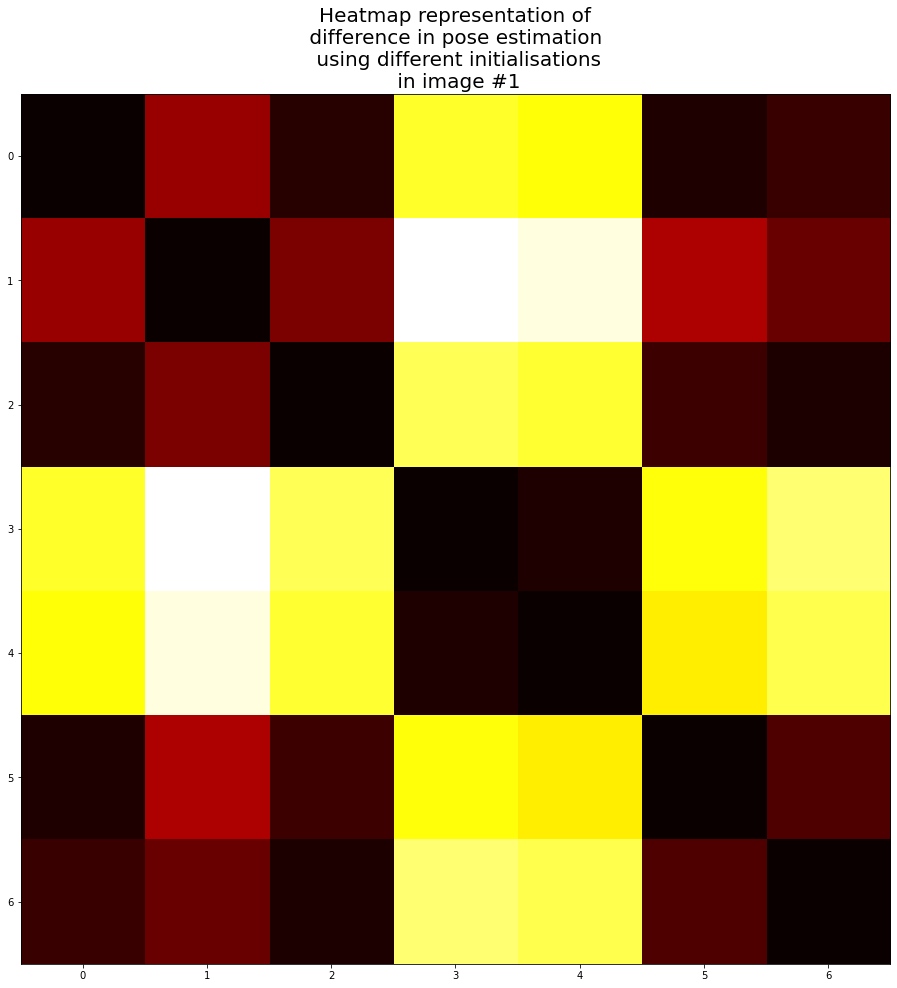

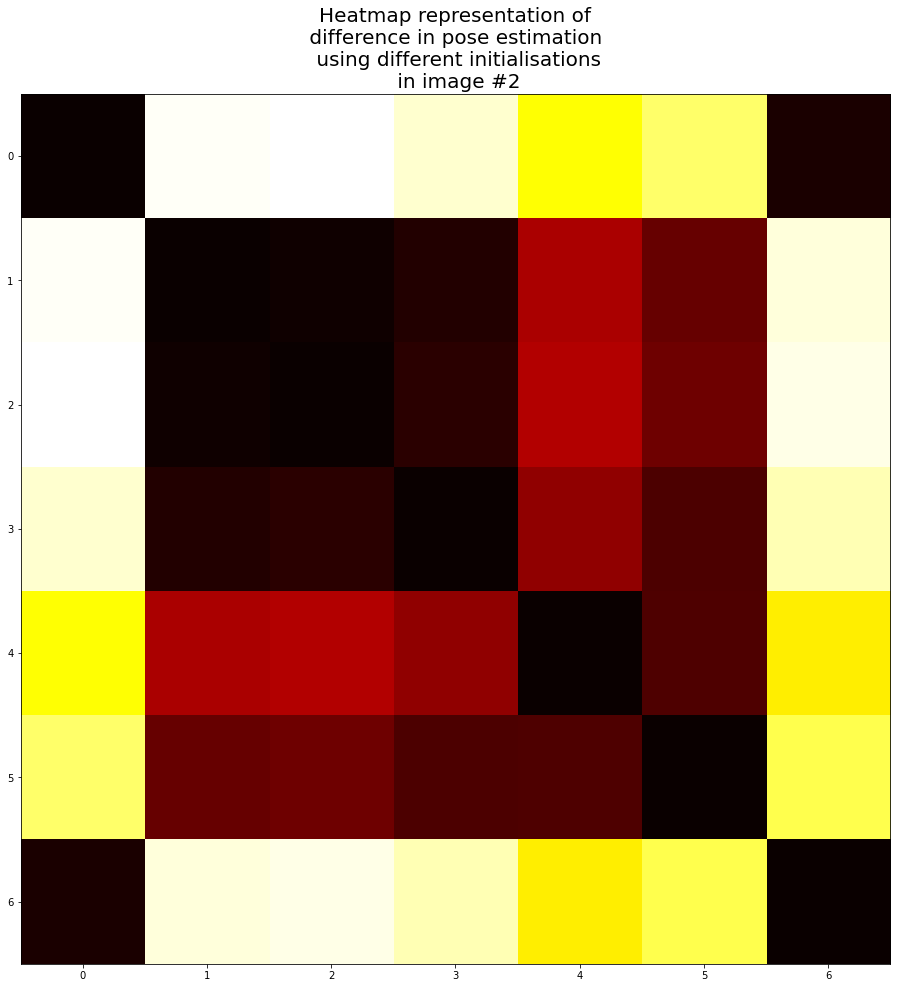

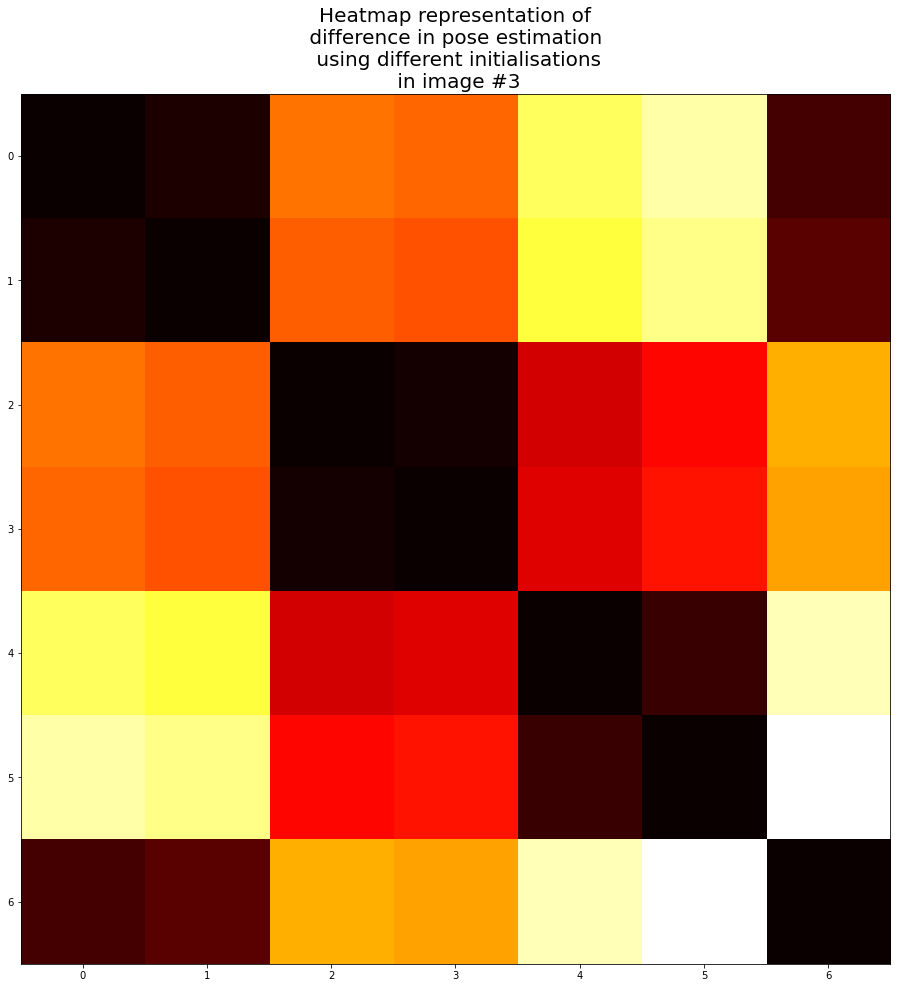

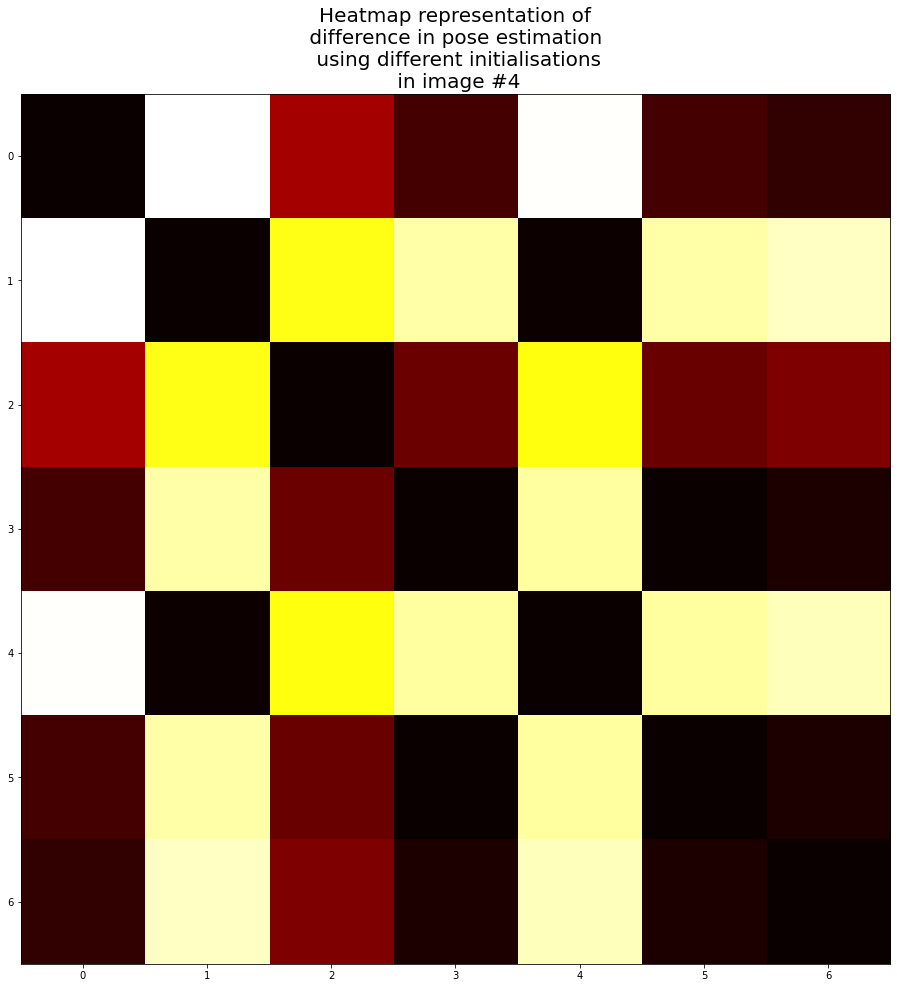

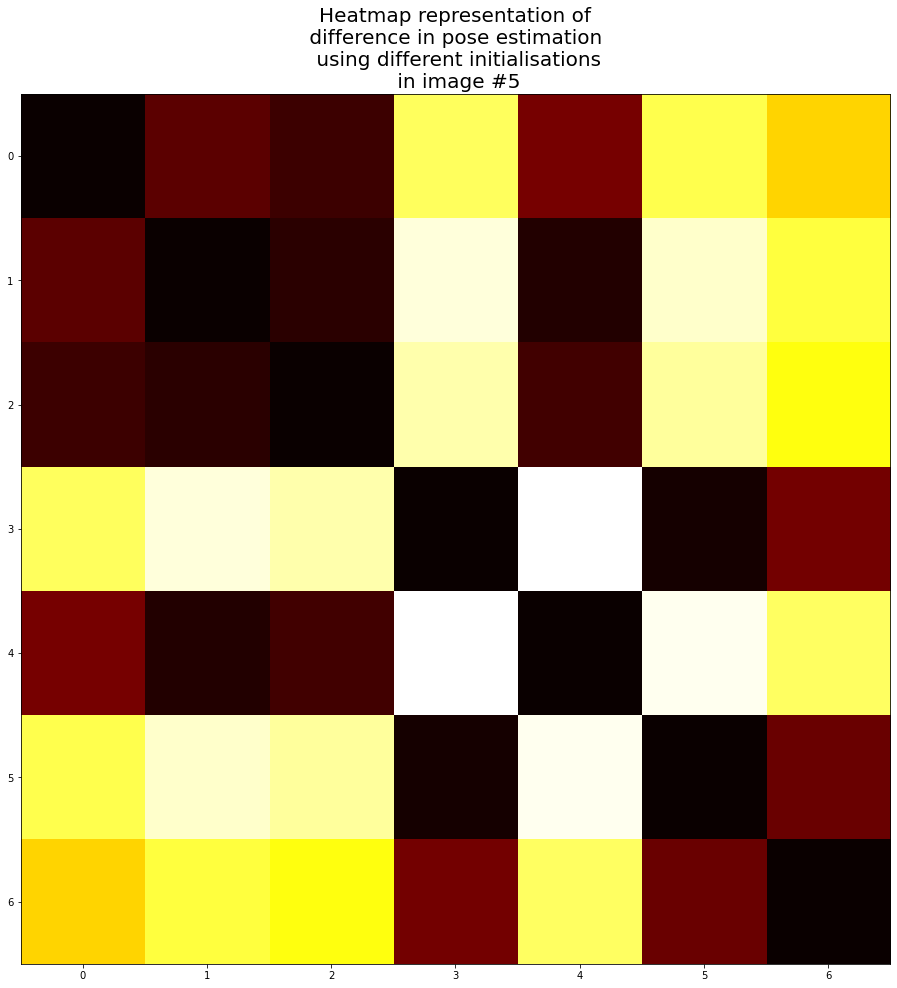

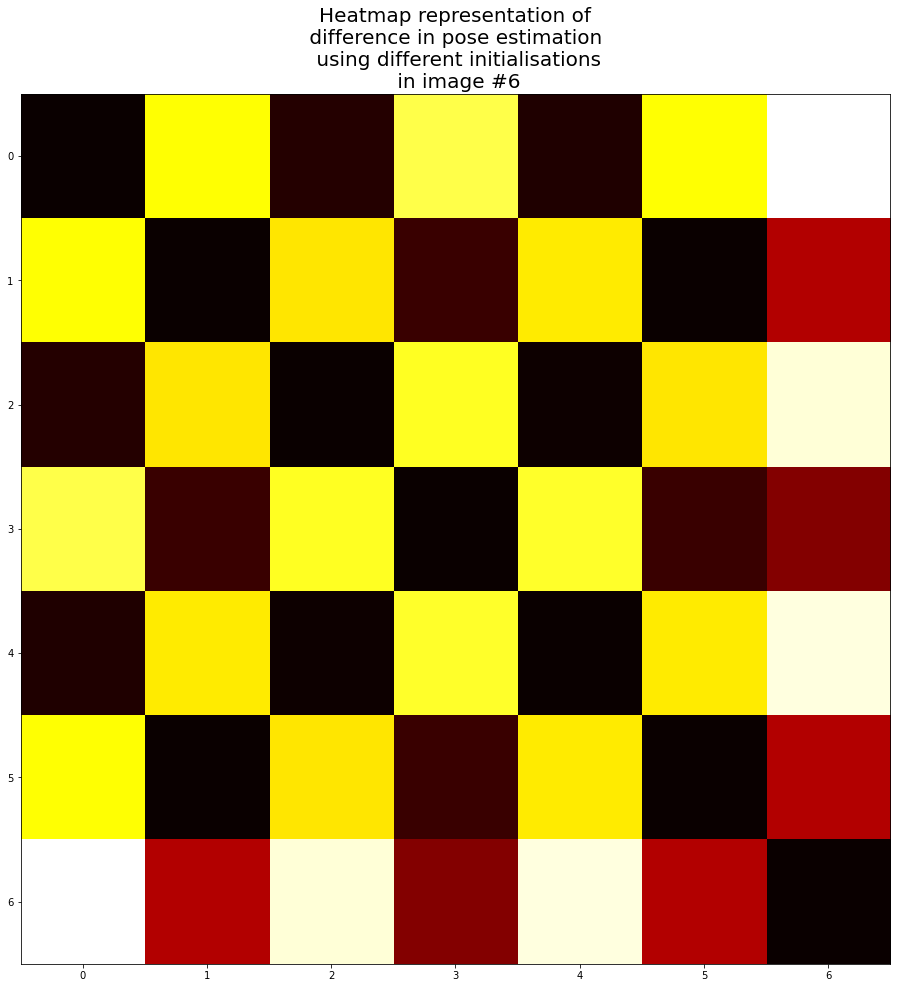

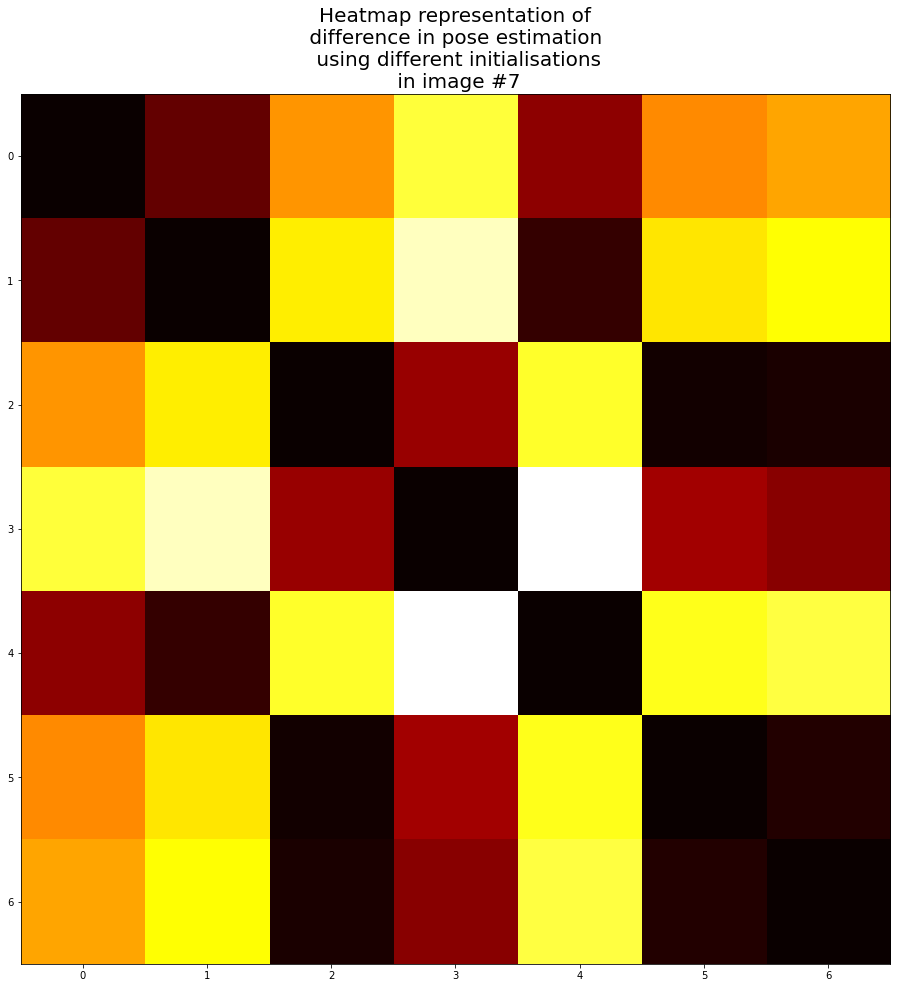

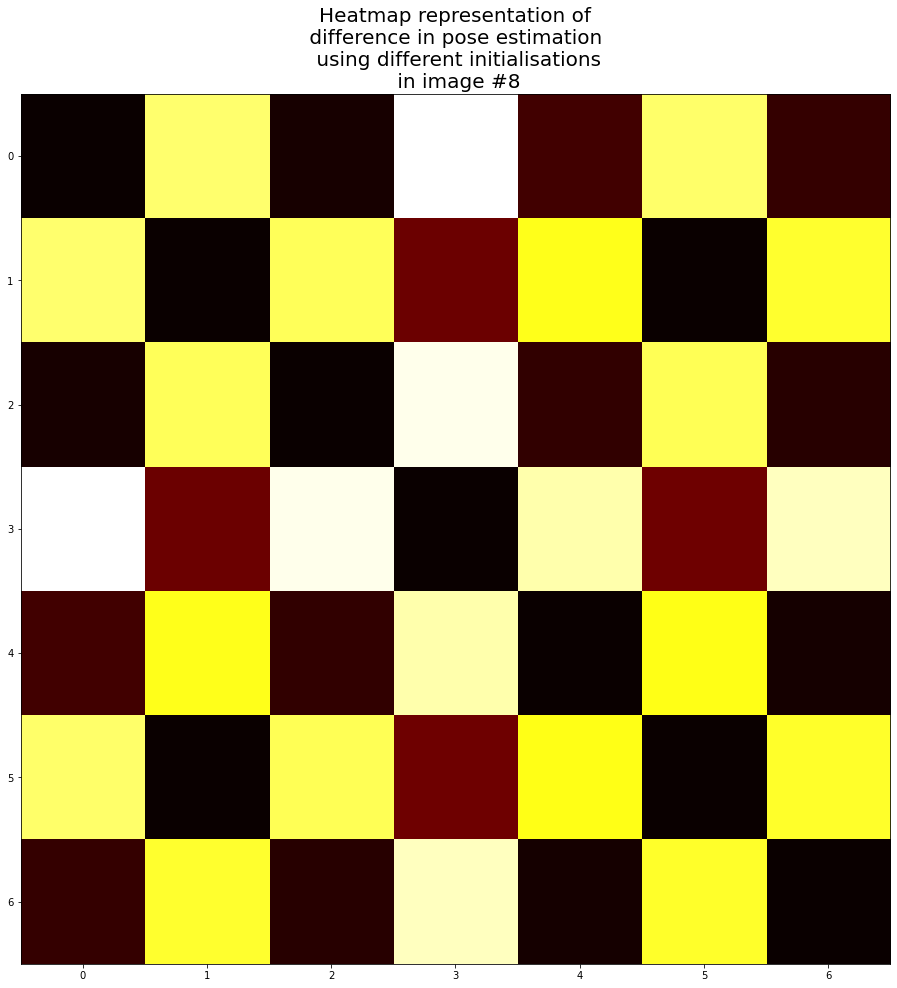

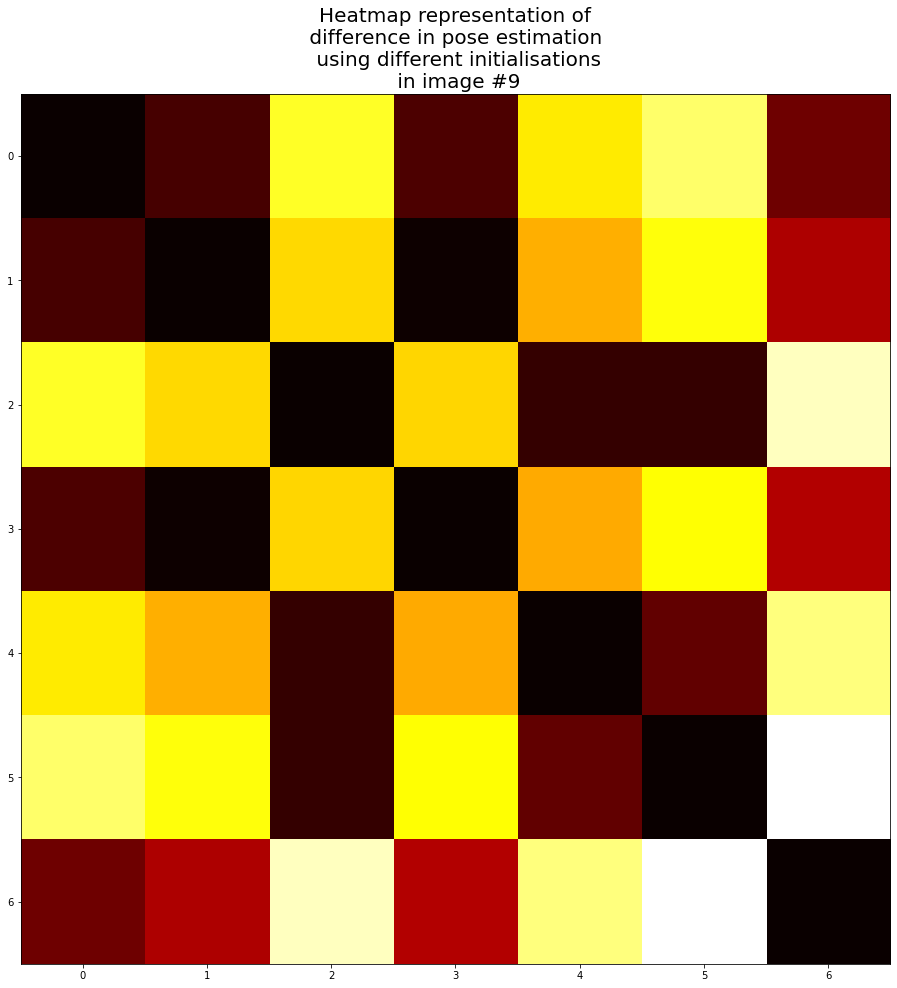

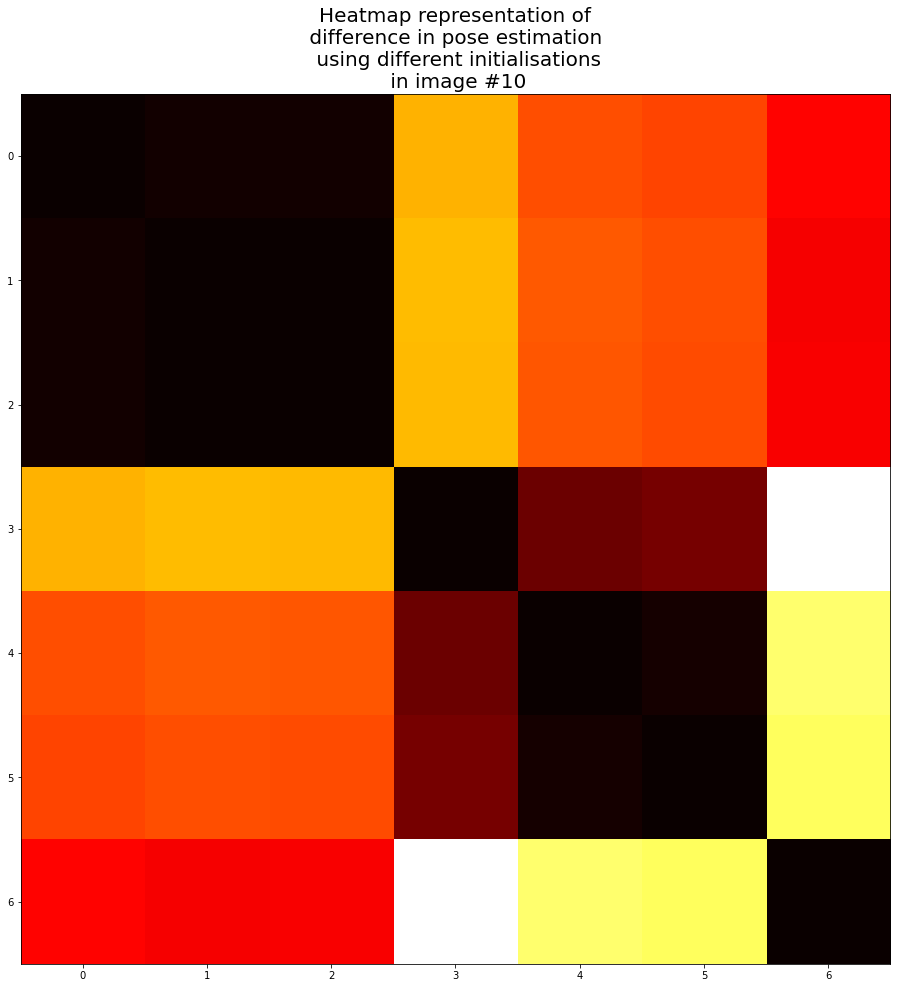

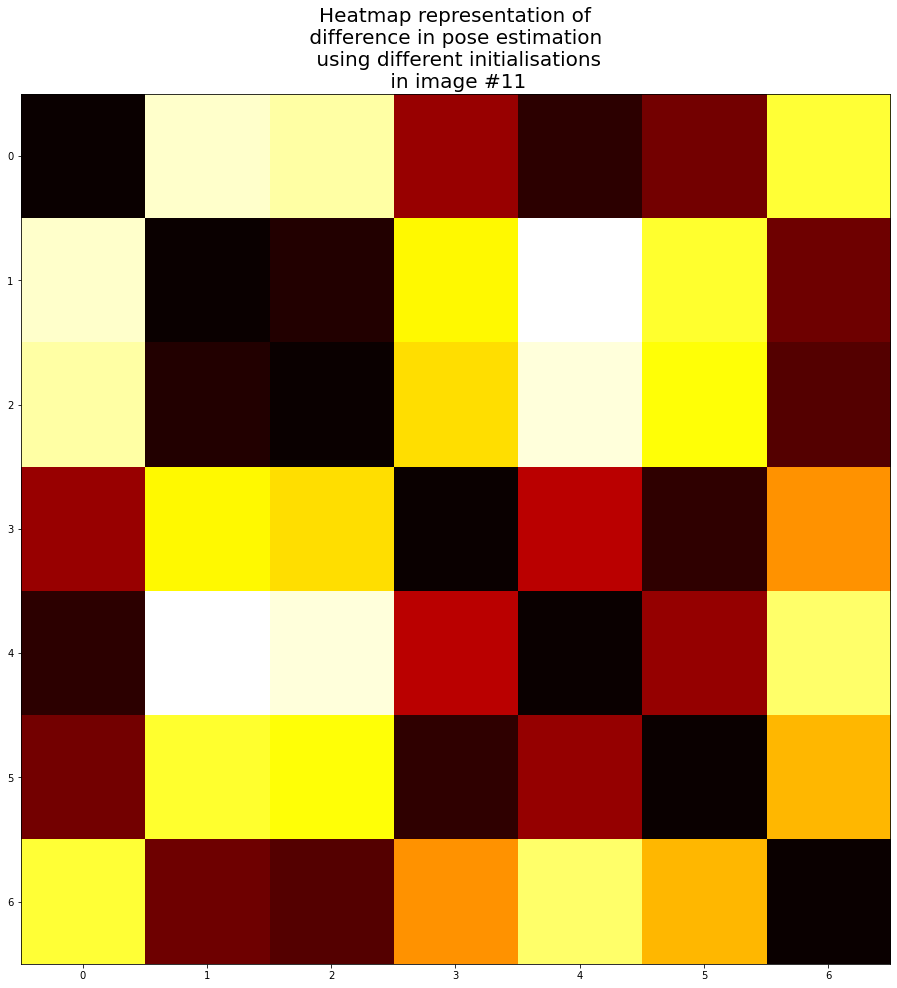

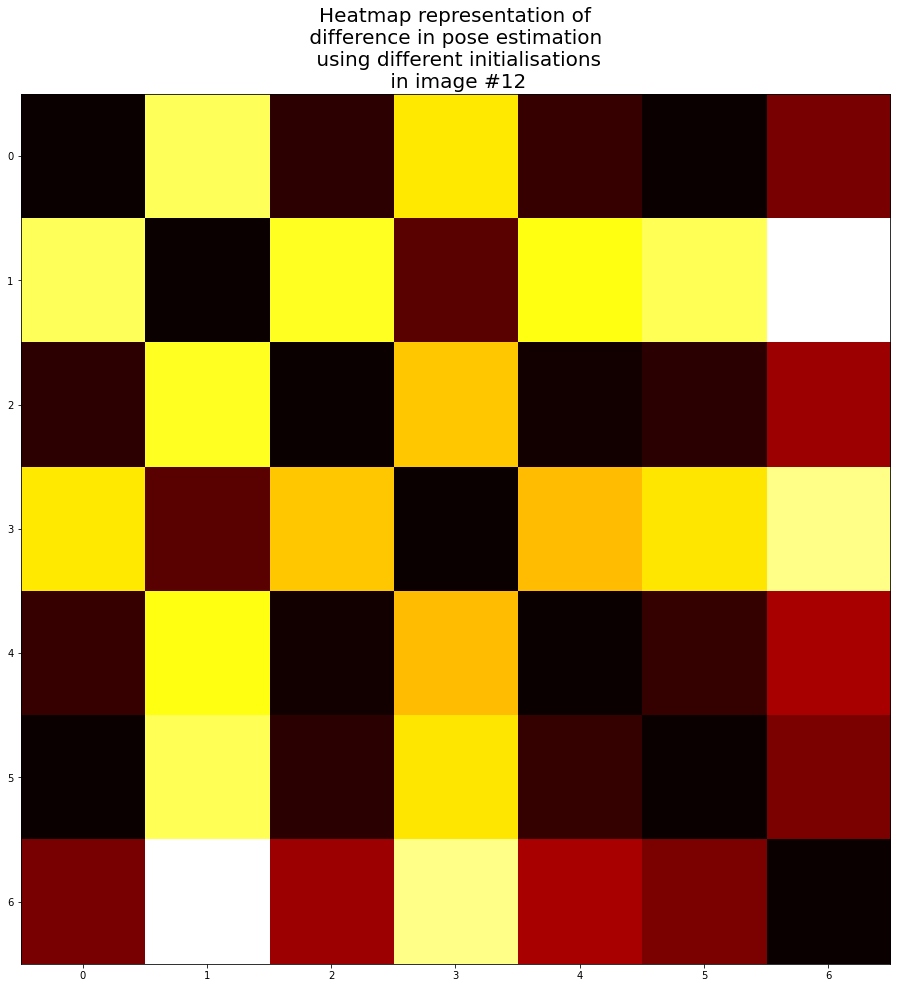

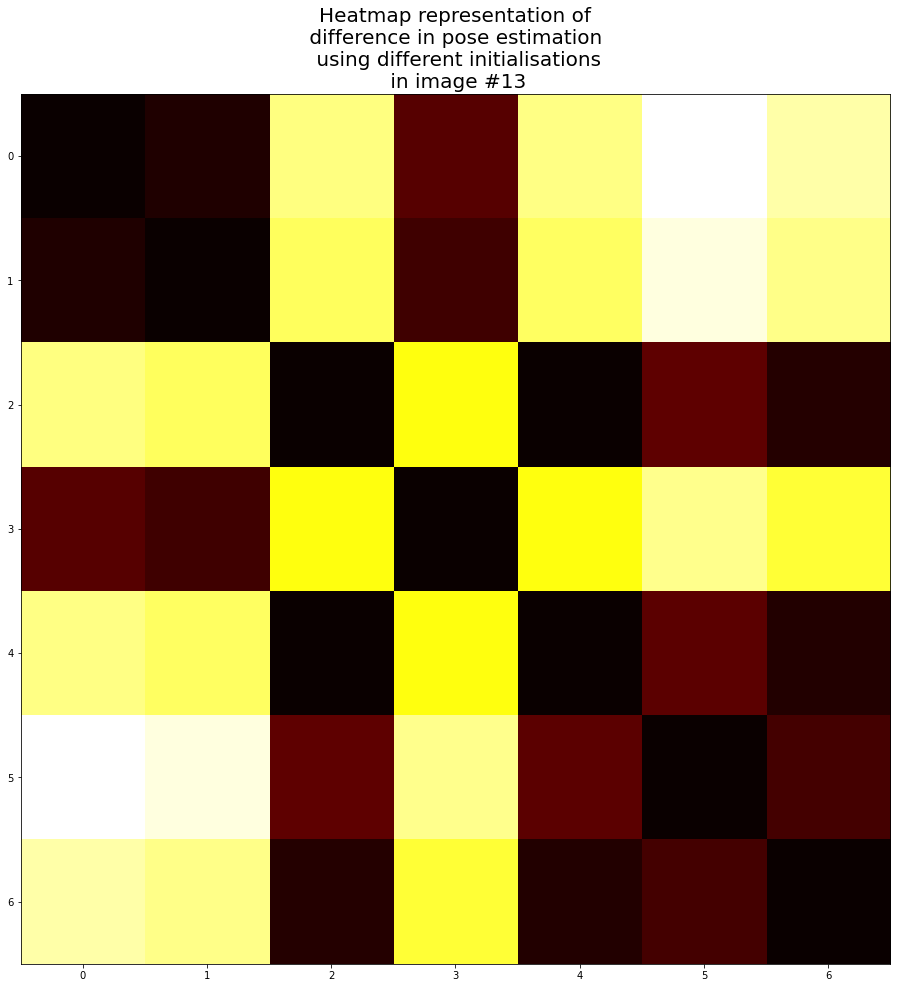

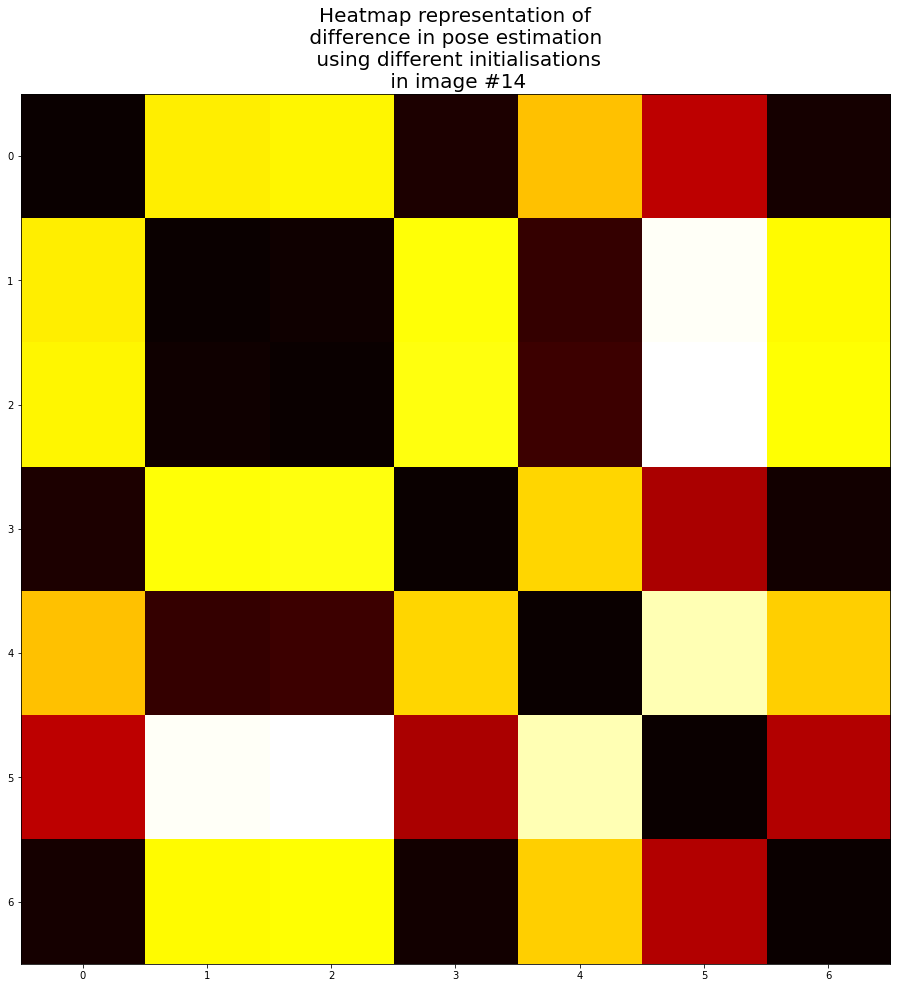

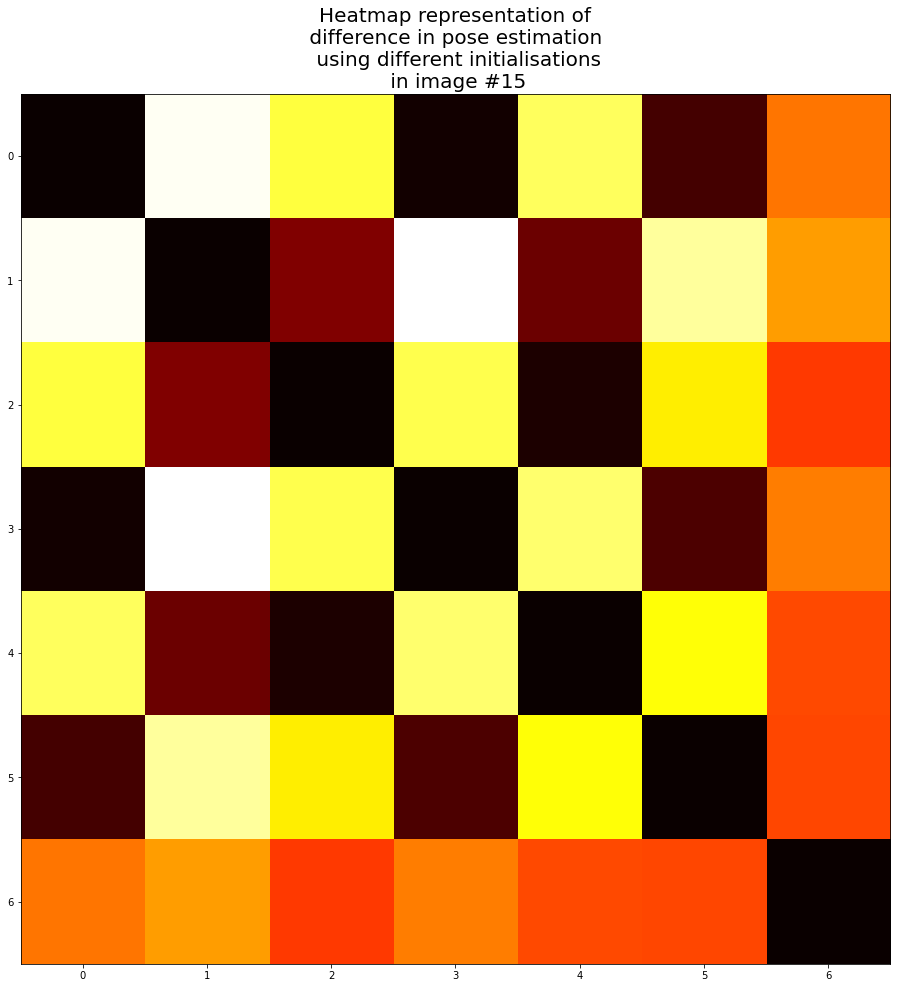

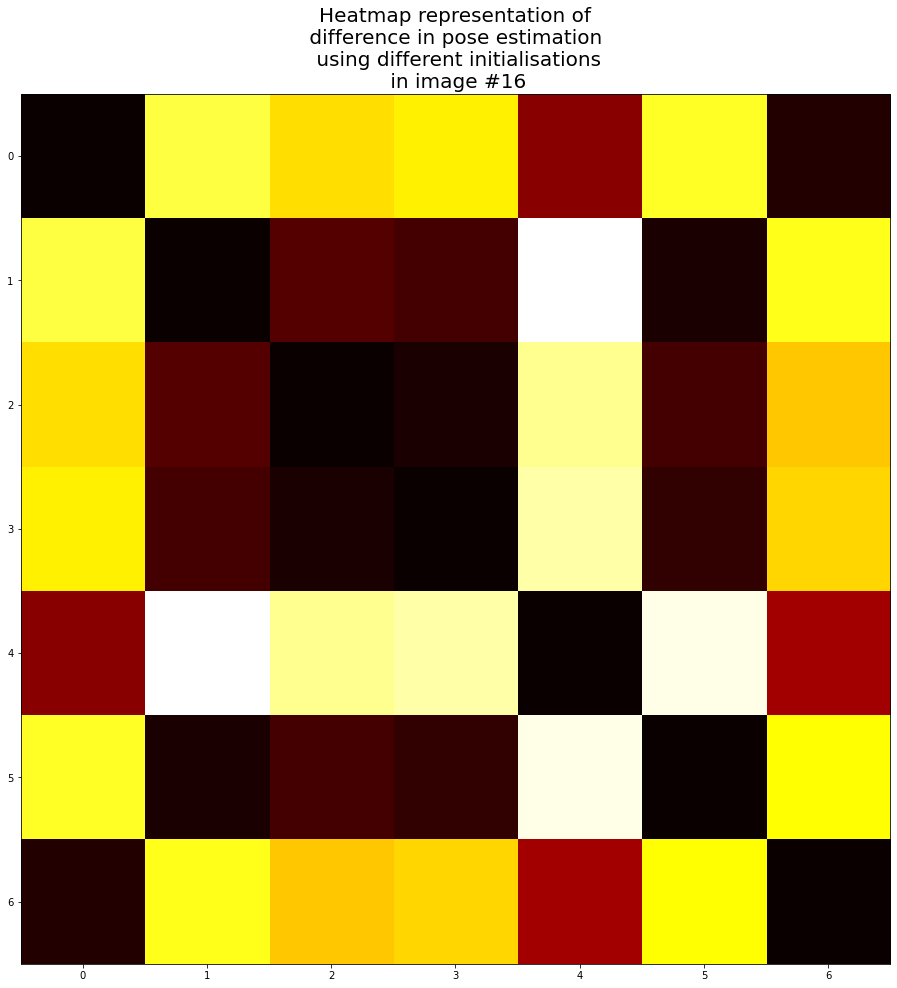

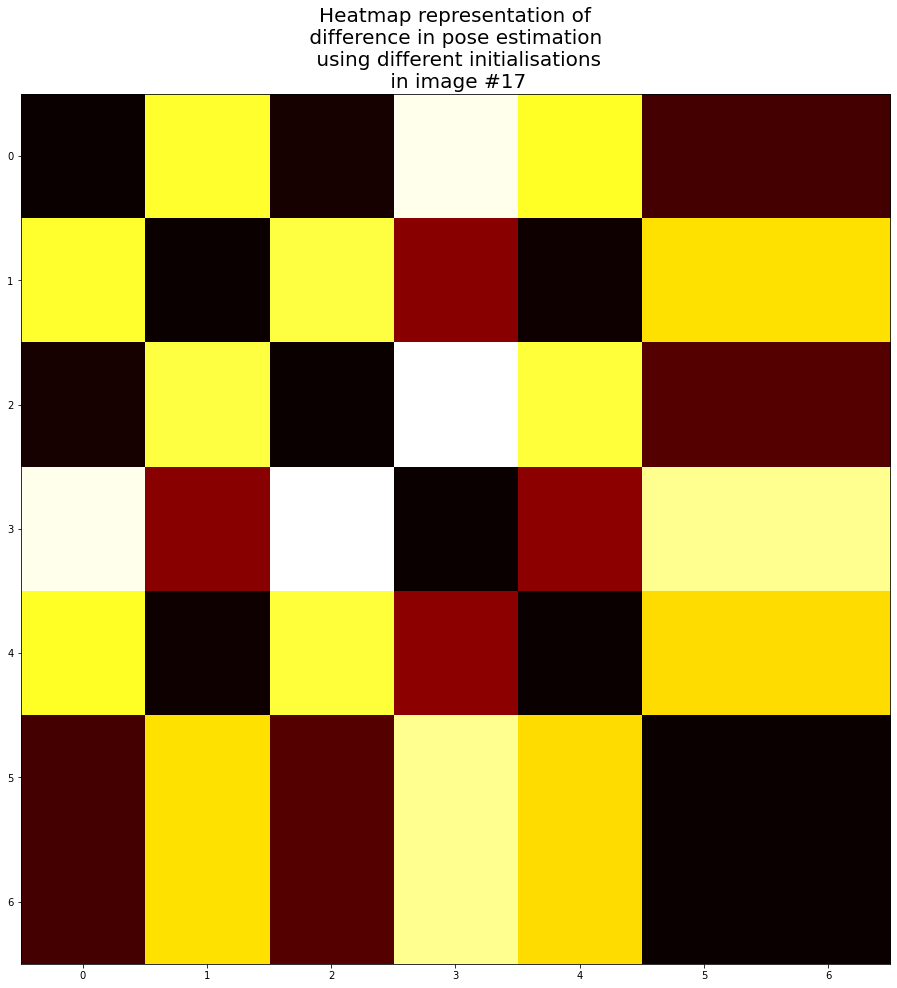

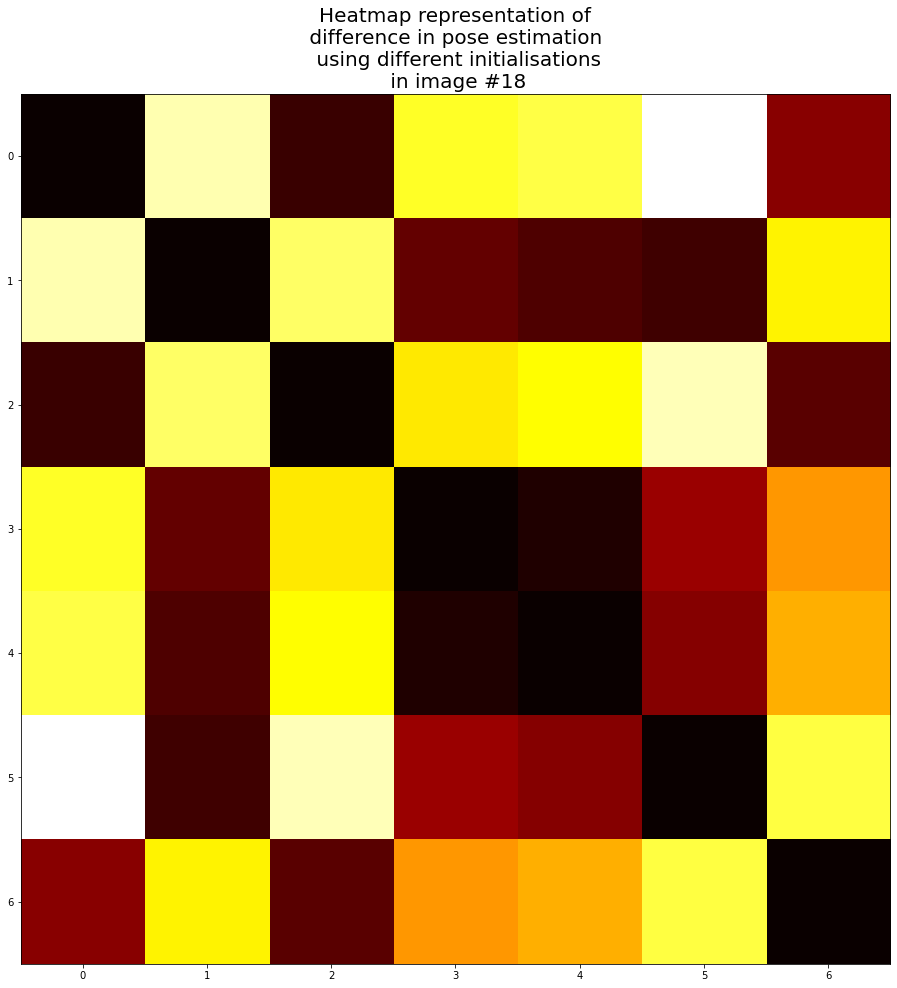

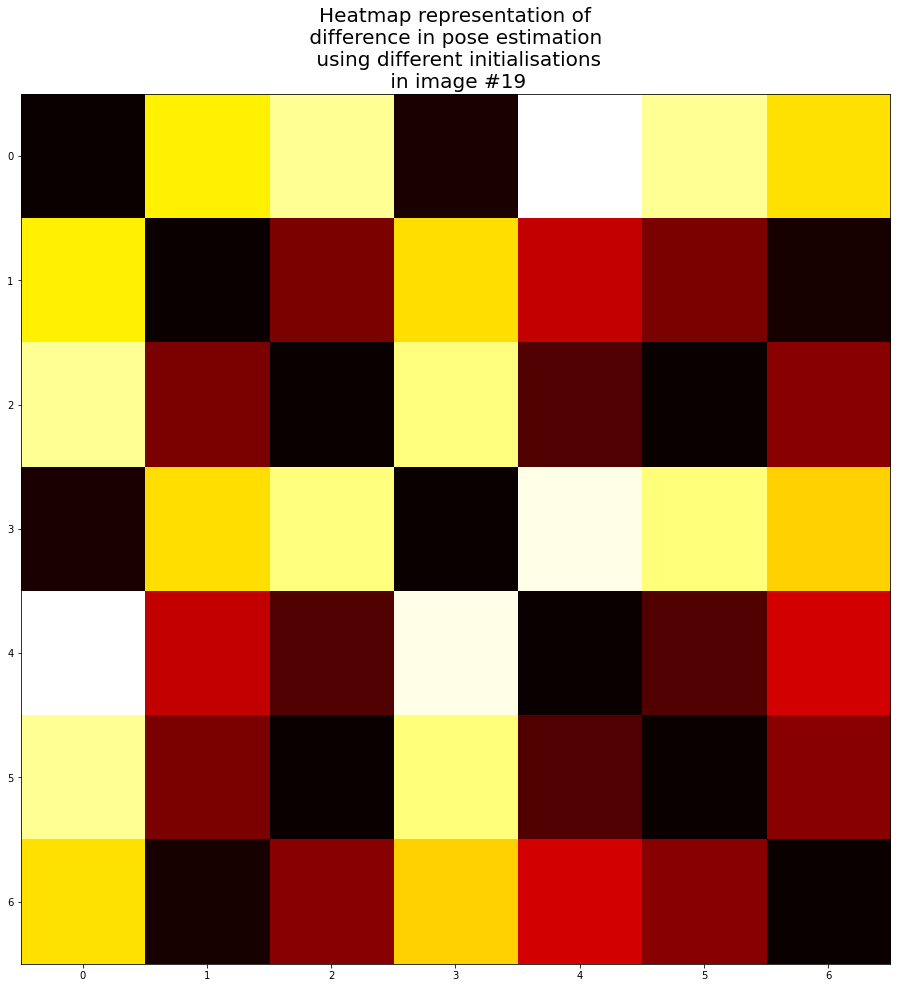

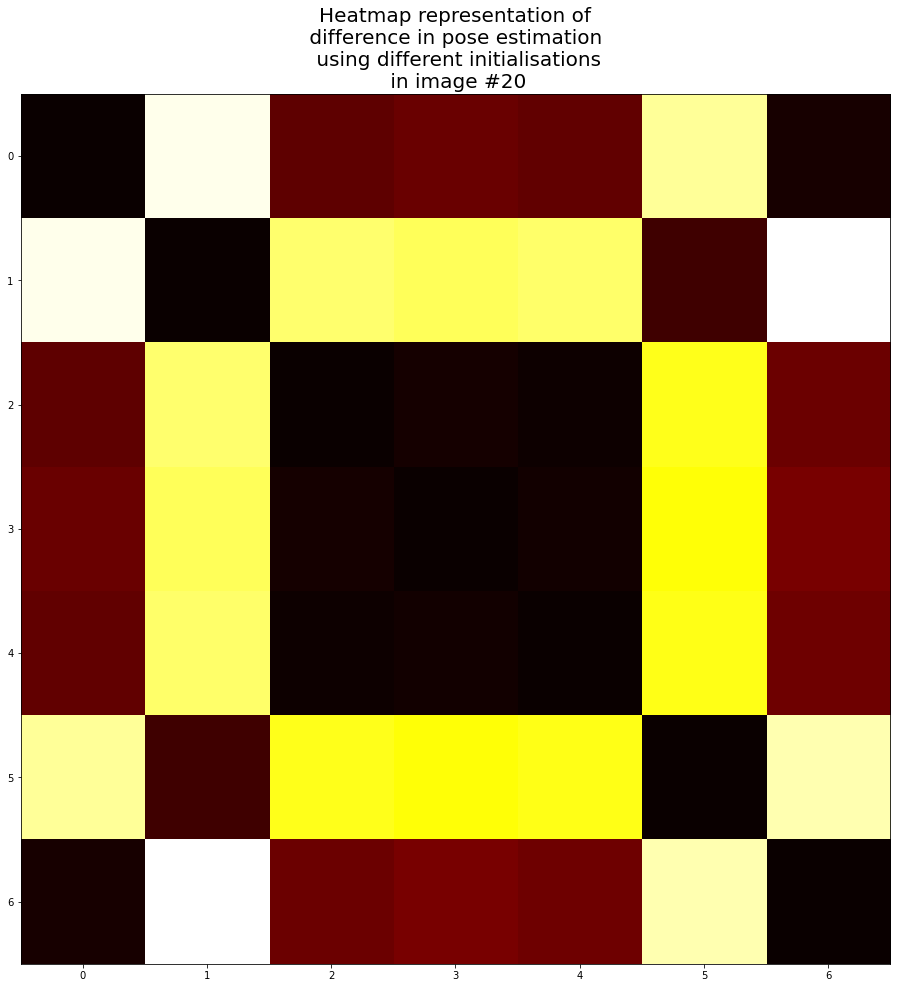

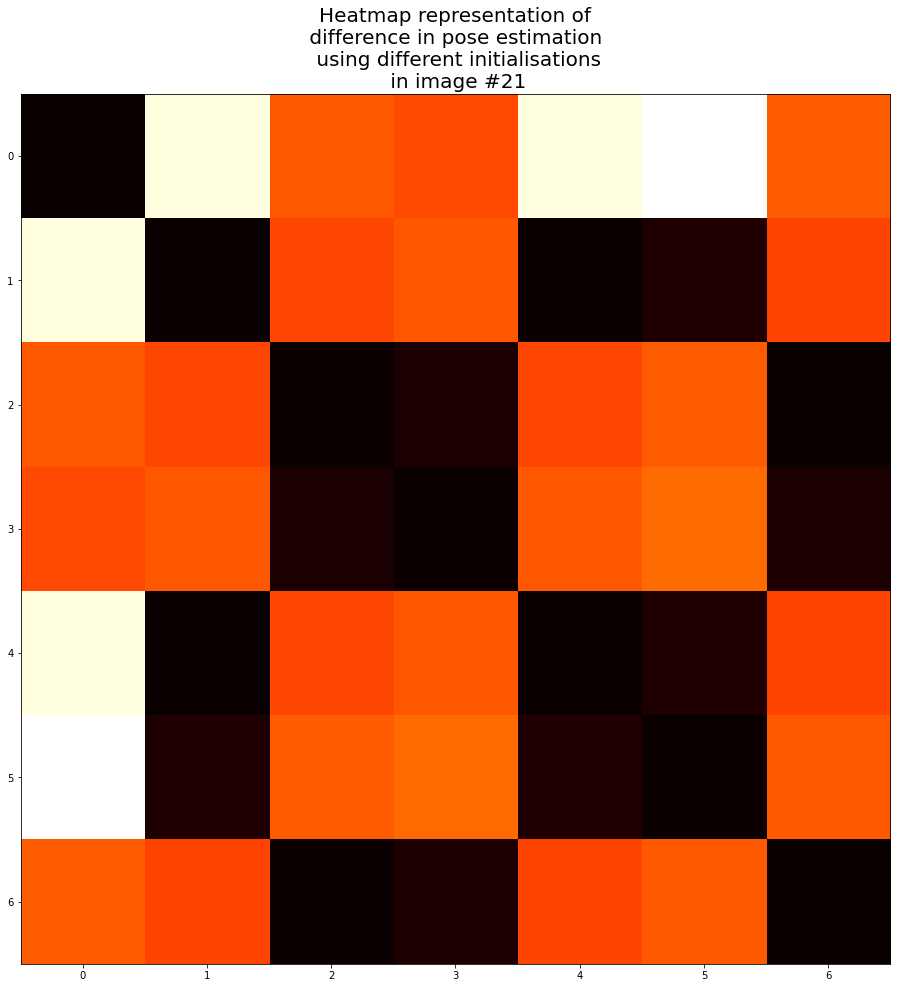

In [12]:
num_pts_dlt = 50
num_pts_opt = 5000
start_pts = np.arange(100,2000,300)
num_iters = 1000
eta = 1

for i in range(sz):
    im_left, im_right = im_list1[i], im_list2[i]
    disparity = (stereo.compute(im_left, im_right) - minDis)/numDis
    world_pts, colors, img_pts = get_3D_pts(disparity, K, b, im_left, return_img_pts=True)
    errs = []
    P_err = []
    for start in start_pts:   
        P = dlt(world_pts.T[start:start+num_pts_dlt], img_pts[start:start+num_pts_dlt], K)    
        P_optim,err = gn_opt(world_pts[:,start:start+num_pts_opt], img_pts[start:start+num_pts_opt], P, K, num_iters, eta, 1e-8)
        errs.append(err)
        P_err.append(P_optim.ravel())
    P_err = np.array(P_err)
    P_err_mat = np.sqrt(np.abs(np.sum(P_err**2,axis=1)[:,np.newaxis] + np.sum(P_err**2,axis=1) - 2*P_err.dot(P_err.T)))
    plt.figure(figsize = [16,16])
    plt.imshow(P_err_mat,cmap='hot')   
    plt.title('Heatmap representation of\n difference in pose estimation \n using different initialisations\n in image #{}'.format(i+1),fontsize = 20)
    plt.show()
#     print('Final error for image#{} is {}'.format(i+1,np.mean(errs)))
    


Provide explanation/observations/any theory you know in this cell: 

Gauss Newton Optimization to Estimate poses using PnP
-----------------------------------------------------
We initialise the pose by running DLT using 7 different sets of points and we got the optimum pose for the 7 initialisations. Then we calculated MSE between 7 diff pose matrices and showed the heatmap. As you can see the lead diagonal is 0 since a matrix and itself should give 0 error otherwise it is horrible.
We see that different inits can give different poses by DLT, so we should use RANSAC to select points for DLT to get best initialisation of a pose.

### Project 2- Part B: Submission details -
You are supposed to gain understanding by playing around with the code above and submit your answers to questions asked below. You shouldn't submit this whole notebook, just copy the following cells (starting next cell up until the end of this notebook) and paste it at the end of your Project 2 notebook (already shared on GitHub classrooms, [link](https://github.com/AryanSakaria/Project_2/blob/main/Project_2.ipynb)).

# Project 2 - Part B:

## 1. SfM pipeline (`6 mark`)

To get the context of below questions, take a look at the code above: The same questions have been asked at different places above as comments in the code.

1. `0.5 mark` **Basics** - How do we know this (`camera_ind`) information in practical setting? In other words, how do we know observations in `points_2d` belong to which camera. Explain. 
    - Ans-1 - Basics: The extrinsic parameters define the position of the camera center and the camera's heading in world coordinates. The position, $C$, of the camera expressed in world coordinates is $C=-R^{-1}T=-R^{T}T$, where $R$ is a rotation matrix, $T$ is the translation. Once we correctly identify camera centres for different images, we are done.
    
    Take a 3d point in the world and project in the image plane along a camera, now try to find which point in 2d we were talking about in the multiple set of points we have now. We assume the `points_ind` is given because it is theoretically possible that 2 distinct 3D points can be imaged in the same 2D point in 2 cameras. If we do not know the correspondences, then we cannot comment on which camera a point was imaged in.
    
2. `0.5 mark` **Basics** - How do we know this (`point_ind`) information in practical setting?  In other words, how do we know observations in `points_2d` belong to which 3D point. Explain.
    - Ans-2 - Basics: Back-project 3D points into camera using $K[R|T]$ to get the 2D points. This establishes the correspondences given in `points_2d`
3. `0.5 mark` **Transformations** - `project()` function: In the `project()` function, would it make any difference if I do translate first, then rotate? Why/why not?
    - Ans-3 - Transformations:
    Yes there is difference. Ideally we want the point to rotate about the center so we should be rotating first, to align the axes of rotation followed by translation to align to the center. This would be different if we translate first, since the axes are not aligned, so the translation would be happening along the wrong plane.
4. `0.5 mark` **Jacobian** - `bundle_adjustment_sparsity()` function: m above is not "M*N" (*2) unlike our lecture notes. Why is that so?
    - Ans-4 - Jacobian: Jacobian has `2*MN` points because of M cameras, N points and 2 axes. However we can understand this if we analyse the Jacobian matrix to see that every row will contain significant values only for `2*m` no. of values, where "m" is no of cameras and 2 again for both axes. We are talking about the non singular terms $J_{11m}$ which are m non singular values and their singular neighbours in the picture above (from your class notes). These values are only important for calculation and can hence be taken for Jacobian (Refer `scipy.sparse.csc_matrix` for more clarity)
5. `2 mark` **Jacobian & Parameters** - `bundle_adjustment_sparsity()` function: 
    1.  Why are we doing `n_cameras * 9` here instead of `n_cameras * 12`? Recollect: Every individual motion Jacobian was (1*)12 in our lecture notes. 
        - Ans 5.1 - Jacobian & Parameters: The camera parameters for `n_cameras * 12` has the rotation **matrix** and translation vector along with intrinsics, however the representation in `n_cameras * 9` uses the rotation **vector** notation, truncating it to total 9 values as mentioned above where the dataset was loaded.
    2. Ignoring the scale parameters, what was the number of unknown parameters in our lecture notes in terms of `n_cameras` and `n_points`? What is it here in the code? Is it different? If so, what is and why? [Link of notes](https://www.notion.so/Stereo-Structure-from-Motion-9fdd81e4194f4803ac9ba7552df56470).
        - Ans 5.2 - Jacobian & Parameters: assume that each camera $j$ is parameterized by a vector $\textbf{a}_{j}$ and each 3D point $i$ by a vector $\textbf{b}_{i}$. If $\kappa$ and $\lambda$ are, respectively, the dimensions of each $\textbf{a}_{j}$ and $\textbf{b}_{i}$, the total number of minimization parameters equals $m\kappa + n\lambda$. It is different from the above mentioned $12 M + 3N$ parameter optimisation. This is because of the sparsity constraint.
6. `2 mark` **Sparsity, Residual Vector & Jacobian** - `bundle_adjustment_sparsity()` function: Explain what you understand from above 6 lines of code by coding a simple toy example yourself to illustrate how it is different from what you've learnt in class. ([Coding toy example + elaborating in words]- both are compulsory.)
    - Ans 6 - Sparsity, Residual Vector & Jacobian: In the Jacobian discussed in class each row represents each observation. The first 12 correspond to camera parameters and the next 3 are world points.For an observation captured in a camera, its response in the other camera will be 0. Hence there will be an alternating pattern of non singular camera points corresponding to non singular world points like the provided diagram. The maximum number of rows that will occur is `2MN`. Now we know that there are ideally `len(camera_indices)` number of points since we would see that each observation would occur uniquely for the camera index, *leaving rows with singular values*.
    </br></br>
    <center>
    <img src="./Assets/jacob_pattern.jpeg">
    </center>
    </br>

## 2. Initializing R,t and 3D points for SfM given 2 images (`4 mark`)

Using OpenCV functions, mention how you would initialize R,t (poses) and 3D points for SfM given 2 images and K matrix. You don't need to implement it, just mention function names with input/output arguments clearly and briefly explain what they do (You don't need to give detailed answers). A sample answer could be as follows:

**Ans 2:**

1. First, we do feature matching using the following function

    `function_name()`: It takes ____ (images?) as input arguments and gives us ____ outputs. These outputs are passed to the next step.

2. ...
3. Now that we have essential matrix, we can decompose it into R,t as following:

    `Rt = cv2.recoverPose(E, pts0, pts1, K)`: This takes Essential matrix, K matrix and the corresponding points in 2 images as input arguments and gives us R,t. `Rt[1]` would give us R and `Rt[2]` would give us t.

4. Now that we have ____, we find 3D points as follows: `TODO`

    (`TODO` )
    
The legit thing uses the following steps.
1. We first find Feature descriptors using `cv2.SurfFeatureDetector` to get 2D location of SURF points followed by `cv2.SurfDescriptorExtractor` to get descriptors. We can use a Brute Force Matcher(`BFMatcher`) or FLANN algorithm to get matchings. This is to establish point correspondences.

2. Now that we have obtained matches between keypoints, we can calculate the fundamental matrix and from that obtain the essential matrix using `cv2.findFundamentalMat`.

3. Next we find the epilines. Epilines corresponding to the points in first image is drawn on second image. Now we find the epilines in both the images and draw them using`cv2.computeCorrespondEpilines`. This will establish the relation between two cameras

4. Use the `Stereo Rectify` function to calculate the R1, R2, P1, P2 matrices of the stereo system. Along with all the other outputs of `Stereo Calibrate`. Then, use the function `undistortPoints` in imgProc that takes the camera matrix, distortion matrix, R and P for that camera and properly undistorts them. `cv2.triangulatePoints` performs stereo-triangulation. Note:
    - `cv2.stereoCalibrate(objectPoints, imagePoints1, imagePoints2, imageSize[, cameraMatrix1[, distCoeffs1[, cameraMatrix2[, distCoeffs2[, R[, T[, E[, F[, criteria[, flags]]]]]]]]]])` calibrates the stereo camera. Returns `retval, cameraMatrix1, distCoeffs1, cameraMatrix2, distCoeffs2, R, T, E, F`. Parameters:	objectPoints – Vector of vectors of the calibration pattern points. imagePoints1 – Vector of vectors of the projections of the calibration pattern points, observed by the first camera. imagePoints2 – Vector of vectors of the projections of the calibration pattern points, observed by the second camera. cameraMatrix1 – Input/output first camera matrix. distCoeffs1 – Input/output vector of distortion coefficients. cameraMatrix2 – Input/output second camera matrix. The parameter is similar to cameraMatrix1. distCoeffs2 – Input/output lens distortion coefficients for the second camera. The parameter is similar to distCoeffs1. imageSize – Size of the image used only to initialize intrinsic camera matrix. R – Output rotation matrix between the 1st and the 2nd camera coordinate systems. T – Output translation vector between the coordinate systems of the cameras. E – Output essential matrix. F – Output fundamental matrix. term_crit – Termination criteria for the iterative optimization algorithm.
    - `cv2.undistortPoints(src, cameraMatrix, distCoeffs[, dst[, R[, P]]])` computes the ideal point coordinates from the observed point coordinates. Returns `dst`. Parameters: src – Observed point coordinates, 1xN or Nx1 2-channel (CV_32FC2 or CV_64FC2). dst – Output ideal point coordinates after undistortion and reverse perspective transformation. If matrix P is identity or omitted, dst will contain normalized point coordinates. cameraMatrix – Camera matrix. distCoeffs – Input vector of distortion coefficients. R – Rectification transformation in the object space (3x3 matrix). R1 or R2 computed by stereoRectify() can be passed here. If the matrix is empty, the identity transformation is used. P – New camera matrix (3x3) or new projection matrix (3x4). P1 or P2 computed by stereoRectify() can be passed here. If the matrix is empty, the identity new camera matrix is used.
    - `cv.StereoRectify(cameraMatrix1, cameraMatrix2, distCoeffs1, distCoeffs2, imageSize, R, T, R1, R2, P1, P2, Q=None, flags=CV_CALIB_ZERO_DISPARITY, alpha=-1, newImageSize=(0, 0))` computes rectification transforms for each head of a calibrated stereo camera. Returns `(roi1, roi2)`. Parameters: cameraMatrix1 – First camera matrix. cameraMatrix2 – Second camera matrix. distCoeffs1 – First camera distortion parameters. distCoeffs2 – Second camera distortion parameters. imageSize – Size of the image used for stereo calibration. R – Rotation matrix between the coordinate systems of the first and the second cameras. T – Translation vector between coordinate systems of the cameras. R1 – Output 3x3 rectification transform (rotation matrix) for the first camera. R2 – Output 3x3 rectification transform (rotation matrix) for the second camera. P1 – Output 3x4 projection matrix in the new (rectified) coordinate systems for the first camera. P2 – Output 3x4 projection matrix in the new (rectified) coordinate systems for the second camera. Q – Output 4 \times 4 disparity-to-depth mapping matrix (see reprojectImageTo3D() ). flags – Operation flags that may be zero or CV_CALIB_ZERO_DISPARITY . If the flag is set, the function makes the principal points of each camera have the same pixel coordinates in the rectified views. And if the flag is not set, the function may still shift the images in the horizontal or vertical direction (depending on the orientation of epipolar lines) to maximize the useful image area. alpha – Free scaling parameter. If it is -1 or absent, the function performs the default scaling. Otherwise, the parameter should be between 0 and 1. alpha=0 means that the rectified images are zoomed and shifted so that only valid pixels are visible (no black areas after rectification). alpha=1 means that the rectified image is decimated and shifted so that all the pixels from the original images from the cameras are retained in the rectified images (no source image pixels are lost). Obviously, any intermediate value yields an intermediate result between those two extreme cases. newImageSize – New image resolution after rectification. The same size should be passed to initUndistortRectifyMap() (see the stereo_calib.cpp sample in OpenCV samples directory). When (0,0) is passed (default), it is set to the original imageSize . Setting it to larger value can help you preserve details in the original image, especially when there is a big radial distortion. validPixROI1 – Optional output rectangles inside the rectified images where all the pixels are valid. If alpha=0 , the ROIs cover the whole images. Otherwise, they are likely to be smaller (see the picture below). validPixROI2 – Optional output rectangles inside the rectified images where all the pixels are valid. If alpha=0 , the ROIs cover the whole images. Otherwise, they are likely to be smaller (see the picture below).
    - `cv2.triangulatePoints(projMatr1, projMatr2, projPoints1, projPoints2[, points4D])` reconstructs points by triangulation. Returns `points4D`. Parameters:	projMatr1 – 3x4 projection matrix of the first camera. projMatr2 – 3x4 projection matrix of the second camera. projPoints1 – 2xN array of feature points in the first image. In case of c++ version it can be also a vector of feature points or two-channel matrix of size 1xN or Nx1. projPoints2 – 2xN array of corresponding points in the second image. In case of c++ version it can be also a vector of feature points or two-channel matrix of size 1xN or Nx1. points4D – 4xN array of reconstructed points in homogeneous coordinates. The function reconstructs 3-dimensional points (in homogeneous coordinates) by using their observations with a stereo camera. Projections matrices can be obtained from `stereoRectify()`.
    